# Video Classification with Transformers

**Name:** Jiban Kumar Shial <br>
**Description:** Training a video classifier with hybrid transformers.

The Video Classification with a CNN-RNN Architecture example was followed up with this example. This time, we'll categorize videos utilizing a Transformer-based model (Vaswani et al.). You will understand how to create hybrid Transformer-based models for video categorization that utilize CNN feature maps after reading this example.

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [20]:
!pip install -q git+https://github.com/tensorflow/docs

## Data collection

As done in the predecessor to
this example, we will be using a subsampled version of the
UCF101 dataset,
a well-known benchmark dataset.

In [21]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## Setup


In [22]:
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import imageio
import pandas as pd
import numpy as np
import cv2
import os

## Define hyperparameters

In [32]:
MAX_SEQ_LENGTH = 20
IMG_SIZE = 220
EPOCHS = [5,7,10,12,15,20,25,30,35,40,50,55,60]
NUM_FEATURES = 1024



## Data preparation
We have done few changes with our data preparation which has mentioned below.

* We reduce the image size to 128x128 instead of 224x224 to speed up computation.
* Instead of using a pre-trained InceptionV3 network,
we use a pre-trained DenseNet121 for feature extraction.
* We directly pad shorter videos to length `MAX_SEQ_LENGTH`.

First, Let's load up the data frames.

In [24]:
df_train= pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print(f"Total Number of videos for training: {len(df_train)}")
print(f"Total Number of videos for testing: {len(df_test)}")

def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)

def feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs_data = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs_data)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs_data, outputs, name="feature_extractor")


def video_load(path,max_frames=0):
    image_frames = []
    cap_video = cv2.VideoCapture(path)
    try:
        while True:
            ret, video_frame = cap_video.read()
            if not ret:
                break
            video_frame = crop_center(video_frame)
            video_frame = video_frame[:, :, [2, 1, 0]]
            image_frames.append(video_frame)

            if len(image_frames) == max_frames:
                break
    finally:
        cap_video.release()
    return np.array(image_frames)


feature_extractor = feature_extractor()


# Lets do the Label preprocessing with StringLookup.
processor_label = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(df_train["tag"]), mask_token=None
)
print(processor_label.get_vocabulary())


def prepare_all_videos(df, root_dir):
    paths_video = df["video_name"].values.tolist()
    samples_num = len(df)
    labels = df["tag"].values
    labels = processor_label(labels[..., None]).numpy()

    # We will be needing the `frame_features` to feed to our sequence model.
    frame_features = np.zeros(
        shape=(samples_num, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(paths_video):
        # Gather all its frames and add a batch dimension.
        frames = video_load(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            length_video = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, length_video)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


Total Number of videos for training: 594
Total Number of videos for testing: 224
['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Calling `prepare_all_videos()` on `train_df` and `test_df` takes ~20 minutes to
complete. For this reason, to save time, here we download already preprocessed NumPy arrays:

In [25]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")
print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


## Building the Transformer-based model

First, the fundamental building components of a Transformer are order-independent self-attention layers. Videos are composed of ordered sequences of frames, thus our Transformer model must account for this fact.
We accomplish this via positional encoding.
With a "Embedding," we merely encode the locations of the frames that are present in videos. These positional embeddings are then added to the previously calculated CNN feature maps.

In [26]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim
    
    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions



Now, we can create a subclassed layer for the Transformer.

In [27]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


## Utility functions for training

In [28]:

def get_model_compiled():
    length_sequence = MAX_SEQ_LENGTH
    num_heads = 1
    embed_dim = NUM_FEATURES
    dense_dim = 4
    classes = len(processor_label.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    emb_input = PositionalEmbedding(
        length_sequence, embed_dim, name="frame_position_embedding"
    )(inputs)
    emb_input = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(emb_input)
    emb_input = layers.GlobalMaxPooling1D()(emb_input)
    emb_input = layers.Dropout(0.5)(emb_input)
    outputs = layers.Dense(classes, activation="softmax")(emb_input)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

accuracy_list=[]
def run_experiment(EPOCHS:int):
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_model_compiled()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    loss, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    a={}
    a["EPOCHS"]=EPOCHS
    a["Accuracy"]=round(accuracy * 100, 2)
    a["loss"]=round(loss , 2) 
    accuracy_list.append(a)

    return model


## Model training and inference

In [29]:
for i in EPOCHS:
   print(f"#####Starting EPOCHS={i}")
   trained_model = run_experiment(i)
   print(f"#####Ending EPOCHS={i}")

#####Starting EPOCHS=12
Epoch 1/12
16/16 [==============================] - ETA: 0s - loss: 1.8505 - accuracy: 0.6389
Epoch 1: val_loss improved from inf to 5.76610, saving model to /tmp/video_classifier
16/16 [==============================] - 15s 766ms/step - loss: 1.8505 - accuracy: 0.6389 - val_loss: 5.7661 - val_accuracy: 0.0000e+00
Epoch 2/12
16/16 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.9464
Epoch 2: val_loss improved from 5.76610 to 0.58619, saving model to /tmp/video_classifier
16/16 [==============================] - 7s 433ms/step - loss: 0.2484 - accuracy: 0.9464 - val_loss: 0.5862 - val_accuracy: 0.8000
Epoch 3/12
16/16 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9821
Epoch 3: val_loss improved from 0.58619 to 0.41134, saving model to /tmp/video_classifier
16/16 [==============================] - 6s 356ms/step - loss: 0.0450 - accuracy: 0.9821 - val_loss: 0.4113 - val_accuracy: 0.8778
Epoch 4/12
16/16 [============

In [30]:
df=pd.DataFrame(accuracy_list)
df

,EPOCHS,Accuracy,loss
0,12,87.95,0.63


**Note**: This model has ~4.23 Million parameters, which is way more than the sequence
model (99918 parameters) we used in the prequel of this example.  This kind of
Transformer model works best with a larger dataset and a longer pre-training schedule.

Test video path: v_TennisSwing_g02_c02.avi
1/1 [==============================] - 0s 229ms/step
  TennisSwing: 99.89%
  Punch:  0.08%
  CricketShot:  0.03%
  PlayingCello:  0.00%
  ShavingBeard:  0.00%



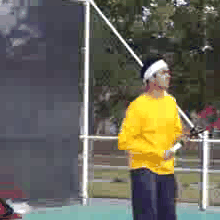

In [31]:

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = processor_label.get_vocabulary()

    frames = video_load(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(df_test["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])